In [ ]:
from quantrocket.zipline import create_usstock_bundle
create_usstock_bundle("usstock-free-1min", free=True)

In [ ]:
from quantrocket.zipline import ingest_bundle
ingest_bundle("usstock-free-1min")

{'status': 'the data will be ingested asynchronously'}

In [ ]:
from quantrocket.license import set_license
set_license('e28e6e06-e03d-11ee-ac0b-75a7adda123c')

{'licensekey': 'e28e........123c', 'software_license': {}}

In [ ]:
from quantrocket.master import collect_usstock_listings
collect_usstock_listings()

{'status': 'success', 'msg': 'already up-to-date'}

In [ ]:
from quantrocket.master import get_securities
securities = get_securities(symbols='AAPL', fields=['Sid','Symbol','Exchange'], vendors='usstock')
securities

In [ ]:
aapl=securities.index[0]

In [ ]:
aapl

'FIBBG000B9XRY4'

In [ ]:
from quantrocket import get_prices
data = get_prices("usstock-free-1min", data_frequency='daily', sids=aapl, start_date='2023-01-01', end_date='2023-12-31', fields="Close")
import pandas as pd
data.to_csv("daily_closing_prices.csv")

In [ ]:
import pandas as pd
df=pd.read_csv("daily_closing_prices.csv")
df.rename(columns={'FIBBG000B9XRY4': 'close price'}, inplace=True)
df

,Field,Date,close price
0,Close,2023-01-03,124.375
1,Close,2023-01-04,125.658
2,Close,2023-01-05,124.325
3,Close,2023-01-06,128.900
4,Close,2023-01-09,129.427
...,...,...,...
245,Close,2023-12-22,193.600
246,Close,2023-12-26,193.050
247,Close,2023-12-27,193.150
248,Close,2023-12-28,193.580


# Line Chart

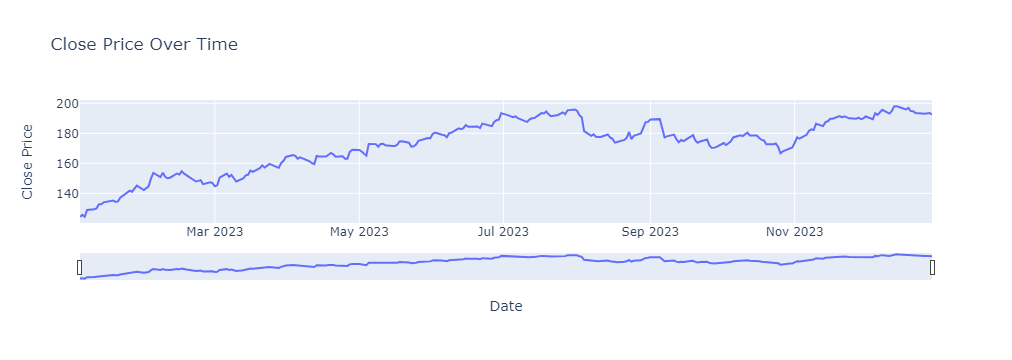

In [ ]:
import plotly.express as px
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create an interactive line chart
fig = px.line(df, x='Date', y='close price', title='Close Price Over Time')

# Enhance the chart with additional options
fig.update_layout(xaxis_title='Date', yaxis_title='Close Price', hovermode='x')
fig.update_xaxes(rangeslider_visible=True)

# Show the plot
fig.show()

# Distribution of Daily Returns

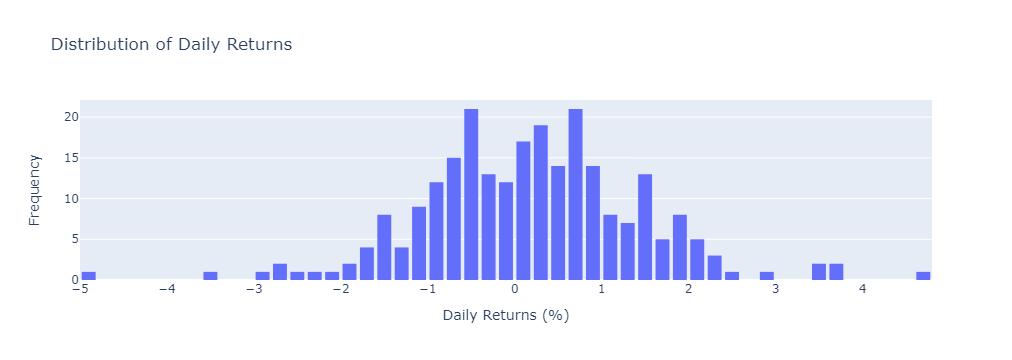

In [ ]:
df.sort_values('Date', inplace=True)

df.loc[:, 'Daily Returns'] = df['close price'].pct_change() * 100

df.dropna(inplace=True)

fig = px.histogram(df, x='Daily Returns', nbins=50, title='Distribution of Daily Returns')

fig.update_layout(xaxis_title='Daily Returns (%)', yaxis_title='Frequency', bargap=0.2)

fig.show()

# Moving Averages and Close Price

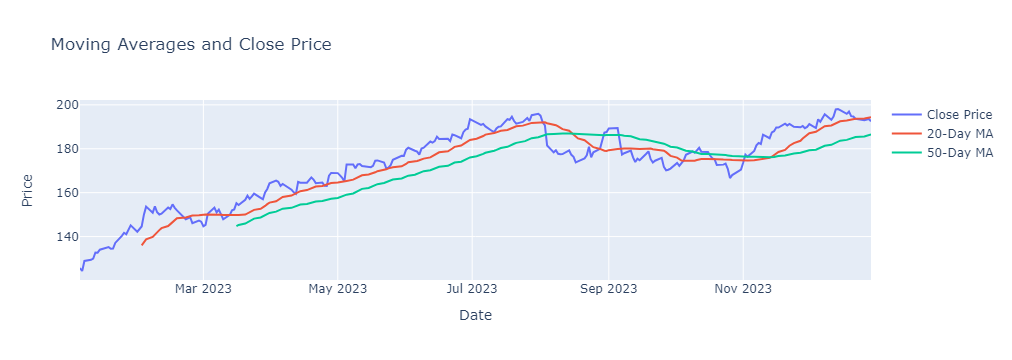

In [ ]:
import plotly.graph_objects as go
df['MA20'] = df['close price'].rolling(window=20).mean()
df['MA50'] = df['close price'].rolling(window=50).mean()

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['close price'], name='Close Price'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], name='20-Day MA'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA50'], name='50-Day MA'))
fig.update_layout(title='Moving Averages and Close Price', xaxis_title='Date', yaxis_title='Price')
fig.show()


Bollinger bands

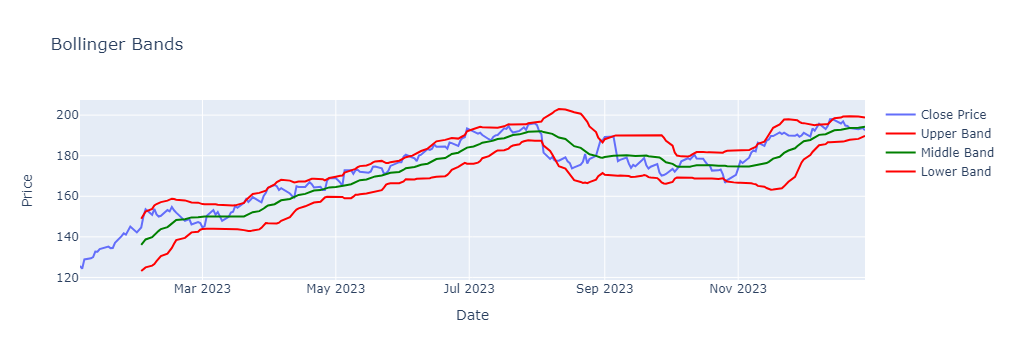

In [ ]:
df['MA20'] = df['close price'].rolling(window=20).mean()
df['STD20'] = df['close price'].rolling(window=20).std()
df['Upper'] = df['MA20'] + (df['STD20'] * 2)
df['Lower'] = df['MA20'] - (df['STD20'] * 2)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['close price'], name='Close Price'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Upper'], name='Upper Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], name='Middle Band', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Lower'], name='Lower Band', line=dict(color='red')))
fig.update_layout(title='Bollinger Bands', xaxis_title='Date', yaxis_title='Price')
fig.show()


# Strategy Development

Approach 1

In [ ]:
import pandas as pd

class PortfolioOptimizer:
    def __init__(self):
        self.portfolio_value = 0  # Initialize portfolio value
        self.transition_probabilities = {'bull': {'bull': 0, 'flat': 0, 'bear': 0},
                                         'flat': {'bull': 0, 'flat': 0, 'bear': 0},
                                         'bear': {'bull': 0, 'flat': 0, 'bear': 0}}
        self.current_state = 'flat'  # Initialize current state
        self.buy_indices = []  # Initialize list to store buy indices

    def calculate_return(self, current_price, previous_price):
        return (current_price - previous_price) / previous_price

    def classify_state(self, returns):
        if returns >= 0.01:
            return 'bull'
        elif returns > -0.01:
            return 'flat'
        else:
            return 'bear'

    def update_transition_counts(self, previous_state, current_state):
        self.transition_probabilities[previous_state][current_state] += 1

    def calculate_transition_probabilities(self):
        for previous_state in self.transition_probabilities:
            total_transitions = sum(self.transition_probabilities[previous_state].values())
            for current_state in self.transition_probabilities[previous_state]:
                self.transition_probabilities[previous_state][current_state] /= total_transitions if total_transitions != 0 else 1 / 3

    def make_decision(self):
        bull_probability = self.transition_probabilities[self.current_state]['bull']
        bear_probability = self.transition_probabilities[self.current_state]['bear']
        if bull_probability > bear_probability:
            return 1
        else:
            return -1

    def execute_trade(self, decision):
        if decision == 1:
            if self.current_state == 'bull':
                self.portfolio_value += 1
        elif decision == -1:
            if self.current_state == 'bear':
                self.portfolio_value -= 1

    def optimize_portfolio(self, data):
        for i in range(1, len(data)):
            current_price = data.iloc[i]['FIBBG000B9XRY4']
            previous_price = data.iloc[i-1]['FIBBG000B9XRY4']
            returns = self.calculate_return(current_price, previous_price)
            current_state = self.classify_state(returns)
            if i > 1:
                previous_state = self.classify_state(self.calculate_return(data.iloc[i-1]['FIBBG000B9XRY4'], data.iloc[i-2]['FIBBG000B9XRY4']))
                self.update_transition_counts(previous_state, current_state)
            self.calculate_transition_probabilities()
            decision = self.make_decision()
            if decision == 1:
                self.buy_indices.append(i)
            self.execute_trade(decision)
            self.current_state = current_state
        return self.portfolio_value, self.buy_indices

if __name__ == "__main__":
    data = pd.read_csv("daily_closing_prices.csv")
    optimizer = PortfolioOptimizer()
    final_portfolio_value, buy_indices = optimizer.optimize_portfolio(data)
    print("Final Portfolio Value:", final_portfolio_value)
    print("Buy Indices:",buy_indices)


Final Portfolio Value: 27
Buy Indices: [3, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28, 30, 32, 34, 37, 40, 41, 42, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 133, 134, 135, 137, 142, 143, 144, 146, 160, 162, 164, 165, 166, 167, 168, 177, 178, 187, 188, 189, 190, 191, 192, 193, 194, 195, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 238, 239, 240, 241, 242]


## Approach 2

In [ ]:
import numpy as np

def calculate_returns(prices):
    returns = np.diff(prices) / prices[:-1]
    return returns

def classify_state(return_value):
    if return_value >= 0.01:
        return 1  # Bull state
    elif return_value > -0.01:
        return 0  # Flat state
    else:
        return -1  # Bear state

def update_transition_probabilities(transitions, counts, from_state, to_state):
    from_index = int(from_state) + 1
    to_index = int(to_state) + 1
    transitions[from_index, to_index] += 1
    counts[from_index] += 1
    probabilities = np.divide(transitions, counts[:, None], out=np.zeros_like(transitions), where=counts[:, None] != 0)
    return probabilities

def dynamic_value_function_update(prices, transitions, counts):
    V = np.zeros(len(prices))  # Initialize the portfolio value function
    buy_indices = []
    states = np.zeros(len(prices))  # Include initial state as Flat

    # Initial state assumed as Flat (0)
    states[0] = 0

    for d in range(1, len(prices)):
        today_return = calculate_returns(prices[d-1:d+1])[0] if d > 1 else 0
        states[d] = classify_state(today_return)
        if d > 1:
            from_state = states[d-1]
            to_state = states[d]
            probabilities = update_transition_probabilities(transitions, counts, from_state, to_state)

            if from_state == 0:
                if probabilities[1, 2] > probabilities[1, 0]:
                    buy_indices.append(d)
                    if to_state == 1:
                        V[d] = V[d-1] + 1
                    elif to_state == -1:
                        V[d] = V[d-1] - 1
                    else:
                        V[d] = V[d-1]
                else:
                    V[d] = V[d-1]
            else:
                V[d] = V[d-1]

    return V, buy_indices, states

transitions = np.zeros((3, 3))
counts = np.zeros(3)
prices=df['close price'].to_numpy()
V, buy_indices, states = dynamic_value_function_update(prices, transitions, counts)
print(f"Final portfolio value: V(N) = {V[-1]}")
print(f"Optimal buy indices: {buy_indices}")


Final portfolio value: V(N) = 18.0
Optimal buy indices: [2, 4, 5, 7, 9, 10, 11, 15, 19, 20, 26, 27, 29, 32, 34, 35, 37, 38, 40, 44, 49, 51, 54, 55, 56, 58, 60, 62, 63, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 95, 96, 98, 99, 102, 104, 105, 106, 107, 109, 111, 112, 114, 115, 116, 118, 119, 121, 122, 124, 125, 126, 127, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 141, 143, 144, 146, 149, 150, 151, 152, 153, 155, 157, 158, 159, 163, 166, 167, 168, 171, 172, 175, 176, 178, 180, 181, 182, 184, 185, 186, 188, 189, 190, 192, 193, 194, 195, 197, 198, 199, 200, 202, 203, 206, 208, 211, 214, 215, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 235, 237, 239, 240, 241, 242, 244, 245, 246, 247, 248]


## Approach 3

In [ ]:
import pandas as pd
import numpy as np

df['Return'] = df['close price'].pct_change()

df['State'] = 0
df.loc[df['Return'] >= 0.01, 'State'] = 1  # Bull
df.loc[df['Return'] <= -0.01, 'State'] = -1  # Bear

df['Portfolio_Value'] = 0
portfolio_value = 0

transition_matrix = np.zeros((3, 3))
state_counts = np.zeros(3)  # Count occurrences of each state

for i in range(1, len(df)):
    current_state = int(df.iloc[i-1]['State'])
    next_state = int(df.iloc[i]['State'])

    state_counts[current_state + 1] += 1
    transition_matrix[current_state + 1, next_state + 1] += 1

    if state_counts[current_state + 1] != 0:
    else:
        transition_probs = np.zeros(3)  # Default to no knowledge if no prior data

    if transition_probs[2] > transition_probs[0]:
        if next_state == 1 and current_state == 0:
            portfolio_value += 1
        elif next_state == -1 and current_state == 0:
            portfolio_value -= 1

    df.iloc[i, df.columns.get_loc('Portfolio_Value')] = portfolio_value

    print(f"Transition Probability Matrix (Step {i}):")
    print(transition_matrix / state_counts[:, None])

final_portfolio_value = df.iloc[-1]['Portfolio_Value']
optimal_buy_indices = [i for i, v in enumerate(df['Portfolio_Value'].diff() > 0) if v]

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Optimal Buy Indices: {optimal_buy_indices}")


Transition Probability Matrix (Step 1):
[[nan nan nan]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 2):
[[ 0.  0.  1.]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 3):
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Transition Probability Matrix (Step 4):
[[0.  0.  1. ]
 [0.5 0.5 0. ]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 5):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 6):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 7):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 8):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 9):
[[0.  0.  1. ]
 [0.2 0.4 0.4]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 10):
[[0.         0.         1.        ]
 [0.16666667 0

/tmp/ipykernel_101/3204253006.py:51: RuntimeWarning:

invalid value encountered in true_divide



## Approach 4

In [ ]:
import pandas as pd
import numpy as np

df['Return'] = df['close price'].pct_change()

df['State'] = 0
df.loc[df['Return'] >= 0.01, 'State'] = 1  # Bull
df.loc[df['Return'] <= -0.01, 'State'] = -1  # Bear

df['Portfolio_Value'] = 0
portfolio_value = 0

transition_matrix = np.zeros((3, 3))
state_counts = np.zeros(3)

for i in range(1, len(df)):
    # Use iloc for positional indexing
    current_state = int(df.iloc[i-1]['State'])
    next_state = int(df.iloc[i]['State'])

    state_counts[current_state + 1] += 1
    transition_matrix[current_state + 1, next_state + 1] += 1

    if state_counts[current_state + 1] != 0:  # Check to avoid division by zero
        transition_probs = transition_matrix[current_state + 1] / state_counts[current_state + 1]
    else:
        transition_probs = np.zeros(3)

    if transition_probs[2] > transition_probs[0]:
        if next_state == 1 and current_state != 1:
            portfolio_value += 1
        elif next_state == -1:  # Sell if moving to Bear state
            portfolio_value -= 1  # Decrease portfolio value

    df.iloc[i, df.columns.get_loc('Portfolio_Value')] = portfolio_value

    print(f"Transition Probability Matrix (Step {i}):")
    print(transition_matrix / state_counts[:, None])

final_portfolio_value = df.iloc[-1]['Portfolio_Value']
optimal_buy_indices = [i for i, v in enumerate(df['Portfolio_Value'].diff() > 0) if v]

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Optimal Buy Indices: {optimal_buy_indices}")


Transition Probability Matrix (Step 1):
[[nan nan nan]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 2):
[[ 0.  0.  1.]
 [ 1.  0.  0.]
 [nan nan nan]]
Transition Probability Matrix (Step 3):
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Transition Probability Matrix (Step 4):
[[0.  0.  1. ]
 [0.5 0.5 0. ]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 5):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 6):
[[0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]]
Transition Probability Matrix (Step 7):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 8):
[[0.   0.   1.  ]
 [0.25 0.25 0.5 ]
 [0.   1.   0.  ]]
Transition Probability Matrix (Step 9):
[[0.  0.  1. ]
 [0.2 0.4 0.4]
 [0.  1.  0. ]]
Transition Probability Matrix (Step 10):
[[0.         0.         1.        ]
 [0.16666667 0

/tmp/ipykernel_101/961377700.py:51: RuntimeWarning:

invalid value encountered in true_divide



## Approach 5

In [ ]:
import numpy as np
import pandas as pd


prices = df['close price'].to_numpy()

returns = np.diff(prices) / prices[:-1]
returns = np.insert(returns, 0, 0)
states = np.where(returns >= 0.01, 1, np.where(returns > -0.01, 0, -1))

transition_counts = np.zeros((3, 3))

for i in range(1, len(states)):
    from_state = states[i - 1] + 1
    to_state = states[i] + 1
    transition_counts[from_state, to_state] += 1

transition_probs = transition_counts / np.maximum(transition_counts.sum(axis=1, keepdims=True), 1)  # Avoid division by zero

V = np.zeros(len(states))
policy = np.zeros(len(states), dtype=bool)

for i in range(len(states)-2, -1, -1):
    if i < len(states) - 2:
        from_state = states[i] + 1
        to_state = states[i + 1] + 1
        transition_counts[from_state, to_state] += 1
        transition_probs = transition_counts / np.maximum(transition_counts.sum(axis=1, keepdims=True), 1)

    if states[i] == 0:
        prob_to_bull = transition_probs[1, 2]  # From Flat to Bull
        prob_to_bear = transition_probs[1, 0]  # From Flat to Bear

        # Decide to buy if more likely to transition to Bull state than Bear state
        if prob_to_bull > prob_to_bear:
            V[i] = V[i + 1] + 1  # Assuming additive value for moving to Bull state
            policy[i] = True
        else:
            V[i] = V[i + 1]
    else:
        V[i] = V[i + 1]

final_portfolio_value = V[0]
buy_indices = [i for i, buy in enumerate(policy) if buy]

print("Final Portfolio Value:", final_portfolio_value)
print("Buy Indices:", buy_indices)


Final Portfolio Value: 158.0
Buy Indices: [0, 3, 4, 6, 8, 9, 10, 14, 18, 19, 25, 26, 28, 31, 33, 34, 36, 37, 39, 43, 48, 50, 53, 54, 55, 57, 59, 61, 62, 64, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 88, 89, 90, 91, 92, 94, 95, 97, 98, 101, 103, 104, 105, 106, 108, 110, 111, 113, 114, 115, 117, 118, 120, 121, 123, 124, 125, 126, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 142, 143, 145, 148, 149, 150, 151, 152, 154, 156, 157, 158, 162, 165, 166, 167, 170, 171, 174, 175, 177, 179, 180, 181, 183, 184, 185, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 199, 201, 202, 205, 207, 210, 213, 214, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 232, 234, 236, 238, 239, 240, 241, 243, 244, 245, 246, 247]


## Apprach 6

In [ ]:
import numpy as np

prices = df['close price'].to_numpy()

returns = np.diff(prices) / prices[:-1]
returns = np.insert(returns, 0, 0)
states = np.where(returns >= 0.01, 1, np.where(returns > -0.01, 0, -1))

transition_counts = np.zeros((3, 3))
n_states = len(states)

V = np.zeros(n_states)
buy_decision = np.zeros(n_states, dtype=bool)

for i in range(1, n_states - 1):
    from_state = states[i-1] + 1  # Adjusting index to start from 0
    to_state = states[i] + 1  # Adjusting index to start from 0
    transition_counts[from_state, to_state] += 1

    transition_probs = transition_counts / np.maximum(transition_counts.sum(axis=1, keepdims=True), 1)  # Avoid division by zero

    if states[i] == 0:
        prob_to_bull = transition_probs[1, 2]
        prob_to_bear = transition_probs[1, 0]

        if prob_to_bull > prob_to_bear:  # If more likely to go Bull
            buy_decision[i] = True
            if i < n_states - 1:  # Ensure we don't look beyond the last index
                if states[i+1] == 1:
                    V[i+1] = V[i] + 1  # Value increases if it goes Bull
                elif states[i+1] == -1:
                    V[i+1] = V[i] - 1  # Value decreases if it goes Bear
                else:
                    V[i+1] = V[i]  # No change if it stays Flat or decision is not to buy
        else:
            V[i+1] = V[i]  # No buy decision
    else:
        V[i+1] = V[i]  # Carry forward value for non-Flat states

final_portfolio_value = V[-1]
buy_days = np.where(buy_decision)[0]

print("Final Portfolio Value:", final_portfolio_value)
print("Days to Place Buy Order:",buy_days
     )

Final Portfolio Value: 15.0
Days to Place Buy Order: [  8   9  10  14  18  19  25  26  28  31  33  34  36  37  39  43  48  50
  53  54  55  57  59  61  62  64  66  67  69  70  71  72  73  74  75  76
  77  79  80  81  82  83  85  86  88  89  90  91  92  94  95  97  98 101
 103 104 105 106 108 110 111 113 114 115 117 118 120 121 123 124 125 126
 128 129 130 131 133 134 136 137 138 139 140 142 143 145 148 149 150 151
 152 154 156 157 158 162 165 166 167 170 171 174 175 177 179 180 181 183
 184 185 187 188 189 191 192 193 194 196 197 198 199 201 202 205 207 210
 213 214 216 218 219 220 221 222 223 224 225 226 227 228 229 230 232 234
 236 238 239 240 241 243 244 245 246 247]


## Approach 7

In [ ]:

import pandas as pd
import numpy as np

class PortfolioOptimizer:
    def __init__(self, data):
        self.data = data
        self.states = self.classify_states()
        self.value_function = np.zeros(len(data))
        self.buy_indices = []

    def classify_states(self):
        returns = self.data['FIBBG000B9XRY4'].pct_change()
        states = returns.apply(lambda r: 1 if r >= 0.01 else (-1 if r <= -0.01 else 0))
        return states

    def optimize_portfolio(self):
        for i in range(1, len(self.data)):
            no_buy_value = self.value_function[i-1]
            if i < len(self.data) - 1:
                tomorrow_state = self.states.iloc[i+1]
                if tomorrow_state == 1 and self.states.iloc[i] == 0:
                    buy_value = self.value_function[i-1] + 1
                elif tomorrow_state == -1 and self.states.iloc[i] == 0:
                    buy_value = self.value_function[i-1] - 1
                else:
                    buy_value = self.value_function[i-1]
            else:
                buy_value = no_buy_value

            if buy_value > no_buy_value:
                self.value_function[i] = buy_value
                self.buy_indices.append(i)
            else:
                self.value_function[i] = no_buy_value

        return self.value_function[-1], self.buy_indices

if __name__ == "__main__":
    data = pd.read_csv("daily_closing_prices.csv")
    optimizer = PortfolioOptimizer(data)
    final_portfolio_value, buy_indices = optimizer.optimize_portfolio()
    print("\nFinal Portfolio Value:", final_portfolio_value)
    print("Optimal Buy Indices:", buy_indices)



Final Portfolio Value: 40.0
Optimal Buy Indices: [5, 7, 11, 15, 20, 27, 29, 40, 49, 51, 58, 60, 68, 78, 84, 87, 93, 99, 102, 107, 109, 112, 116, 119, 122, 132, 141, 159, 163, 176, 186, 190, 206, 208, 211, 215, 217, 231, 233, 237]


# Backtest of a Moving Average Crossover Strategy

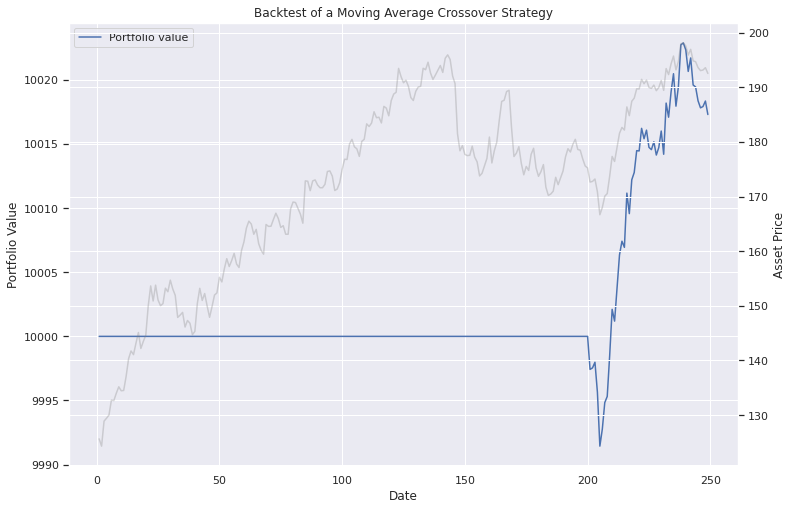

Cumulative Returns: 0.17%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df['Short_MA'] = df['close price'].rolling(window=50).mean()
df['Long_MA'] = df['close price'].rolling(window=200).mean()

df['Signal'] = 0

df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, 0)

df['Position'] = df['Signal'].diff()

initial_capital = float(10000.0)
positions = pd.DataFrame(index=df.index).fillna(0.0)
positions['Asset'] = df['Signal']

portfolio = positions.multiply(df['close price'], axis=0)
pos_diff = positions.diff()

portfolio['Holdings'] = (positions.multiply(df['close price'], axis=0)).sum(axis=1)
portfolio['Cash'] = initial_capital - (pos_diff.multiply(df['close price'], axis=0)).sum(axis=1).cumsum()
portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']
portfolio['Returns'] = portfolio['Total'].pct_change()

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(portfolio['Total'], label='Portfolio value')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value')
ax2 = ax1.twinx()
ax2.plot(df['close price'], color='grey', alpha=0.3)
ax2.set_ylabel('Asset Price')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

plt.title('Backtest of a Moving Average Crossover Strategy')
plt.show()

cumulative_returns = (portfolio['Total'].iloc[-1] / portfolio['Total'].iloc[0]) - 1

print(f"Cumulative Returns: {cumulative_returns:.2%}")


# AAPL Daily Returns State Classification

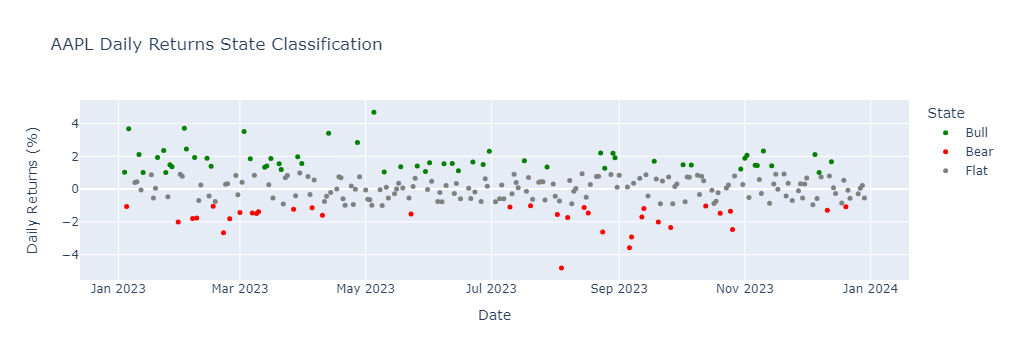

In [ ]:
df['State'] = states
state_map = {-1: 'Bear', 0: 'Flat', 1: 'Bull'}
df['State'] = df['State'].map(state_map)

import plotly.express as px

fig = px.scatter(df, x='Date', y='Daily Returns', color='State', title='AAPL Daily Returns State Classification',
                 color_discrete_map={'Bear': 'red', 'Flat': 'grey', 'Bull': 'green'})
fig.update_traces(marker=dict(size=5))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Daily Returns (%)')
fig.show()
